<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/IE_423_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import and Some Functions

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
def upload_dataset(from_drive = False):
  if not os.path.exists("kaggle.json"):
    if not from_drive:
      print("Upload Kaggle API Key")
      files.upload()
      print("Downloading dataset...")
    else:
      !cp /content/drive/MyDrive/kaggle.json /content/
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d hariharanpavan/bank-marketing-dataset-analysis-classification
    !unzip bank-marketing-dataset-analysis-classification.zip
  else:
    print("Dataset already exists")

In [3]:
#We start with basic statistics for both numeric and categorical data
def unistats(dataframe,sorted="Missing"):
    """"
    Takes dataframe and sorted as parameter
    Returns count, missing, unique, dtype, mode and other stats"""
    pd.set_option("display.max_rows",100)
    pd.set_option("display.max_columns",100)
    output_df = pd.DataFrame(columns = ["Count","Missing","Unique", "Dtype", "Mode", "Mean", "Min", "25%", "Median", "75%", "Max", "Std", "Skew", "Kurt"])

    for col in dataframe:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype ,dataframe[col].mode().values[0], dataframe[col].mean(), dataframe[col].min(), dataframe[col].quantile(0.25), dataframe[col].median(), dataframe[col].quantile(0.75),dataframe[col].max(), dataframe[col].std(), dataframe[col].skew(),dataframe[col].kurt()]
        else:
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype , "-", "-", "-","-", "-", "-","-", "-", "-","-"]


    return output_df.sort_values(by = ["Dtype",sorted])

In [4]:
#Lets make an anova test to see if this much category is needed
def barplots(dataframe, label, target):
    from scipy import stats
    """
    Takes dataframe, feature and target as parameter
    Applies t-tests for categorical features
    Returns a barpot with t-stat and p values"""
    ttests = []
    string = "Categories  t stat  p value \n "
    if pd.api.types.is_numeric_dtype(dataframe[label]) == False and len(dataframe[label].unique()) <= 20 and len(dataframe[label].unique())>=2:
        e_types = dataframe[label].unique()
        for i, e in enumerate(e_types):
            for i2, e2 in enumerate(e_types):
                if i2 >= i :
                    g1 = dataframe[dataframe[label] == e][target]
                    g2 = dataframe[dataframe[label] == e2][target]
                    t, p = stats.ttest_ind(g1,g2)
                    ttests.append([f"{e} - {e2}", t, p])
                    string += (f"{e} - {e2}: {t:.4f}, {p:.5f} " + " \n ")
                    if p < 0.05:
                        string += "Significant" + "\n"
                    else:
                        string += "Not Significant" + "\n"
        plt.figure()
        plt.figsize=(10,6)
        plt.text(5, 0.1, string, fontsize = 8)
        viz = sns.barplot(data = dataframe, x = label , y = target,)
        viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)
        viz.set(title = f"{target} by {label}")
        plt.show()

In [5]:
#To start visualizing data, lets first see the best features in terms of explainin the variance of target
def correlation(dataframe, target):
    from scipy import stats
    """
    Takes dataframe and target feature as parameter
    Returns the correlation between numeric columns and target"""

    output_dataframe = pd.DataFrame(columns = ["Columns","P-Value","Correlation Coefficient(r)","Absolute r"])
    for col in dataframe.drop(target,axis = 1):
        try:
            if pd.api.types.is_numeric_dtype(dataframe[col]):
                r, p = stats.pearsonr(dataframe[col],dataframe[target])
                output_dataframe.loc[col] = [f"{target}-{col}",round(p,4),r,abs(r)]
            else:
                pass
        except:
            pass

    return output_dataframe.sort_values(by = ["Absolute r"],ascending = False)

In [6]:
def hist_and_boxplot(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns histogram and boxplot"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.histplot(data = dataframe, x = label)
    plt.subplot(1,2,2)
    sns.boxplot(data = dataframe, x = label)
    plt.show();

In [7]:
def categorical_pie(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns pie chart along with value counts"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    dataframe[label].value_counts().plot.pie(autopct = "%1.1f%%")
    plt.subplot(1,2,2)
    sns.countplot(data = dataframe, x = label)

In [8]:
def scatter(dataframe, target, feature):
    from statsmodels.formula.api import ols
    from statsmodels.stats.diagnostic import het_breuschpagan
    from scipy import stats
    """
    Takes dataframe, target and feature as parameter
    Use it with a numeric column
    Fits an OLS model with the given feature
    Applies breuschpagan test
    Returns the scatterplot, regression and test results.
    """

    sns.set_style(style="white")

    model = ols(formula= f"{target}~{feature}", data = dataframe).fit()

    lm, p1, f, p2 = het_breuschpagan(model.resid,model.model.exog)
    m, b, r, p, err = stats.linregress(dataframe[feature], dataframe[target])

    string = "y = " + str(round(m,2)) + "x " + str(round(b,2)) + "\n"
    string += "r_2 = " + str(round(r**2, 4))  + "\n"
    string += str(round(r**2, 4)*100) + "% of variance is explained" + "\n"
    string += "p = " + str(round(p, 5)) + "\n"
    if p < 0.05:
        string += "Significant" + "\n"
    else:
        string += "Not Significant" + "\n"
    string += str(dataframe[feature].name) + " skew = " + str(round(dataframe[feature].skew(), 2)) + "\n"
    if dataframe[feature].skew() < 0:
        string += str(dataframe[feature].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[feature].name) + " is positively skewed" + "\n"
    string += str(dataframe[target].name) + " skew = " + str(round(dataframe[target].skew(), 2)) + "\n"
    if dataframe[target].skew() < 0:
        string += str(dataframe[target].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[target].name) + " is positively skewed" + "\n"
    string += str(dataframe[feature].name) + " Breushpagan Test = " + "LM stat: " + str(round(lm,4)) + " p value: " + str(round(p1,4)) + " F stat: " + str(round(f,4)) + " p value: " + str(round(p2,4)) + "\n"
    if p1 < 0.05:
        string += "Variance of residuals are not distributed equally" + "\n"
    else:
        string += "Variance of residuals are distributed equally" + "\n"
    ax = sns.jointplot(x = feature, y = target, kind = "reg", data = dataframe)
    ax.fig.text( 1, 0.1, string, fontsize = 12, transform = plt.gcf().transFigure)


In [9]:
upload_dataset()

Dataset already exists


# EDA

In [10]:
df = pd.read_csv("bank-full.csv")

In [11]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [13]:
unistats(df)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
age,45211,0,77,int64,32,40.93621,18,33.0,39.0,48.0,95,10.618762,0.684818,0.31957
balance,45211,0,7168,int64,0,1362.272058,-8019,72.0,448.0,1428.0,102127,3044.765829,8.360308,140.751547
day,45211,0,31,int64,20,15.806419,1,8.0,16.0,21.0,31,8.322476,0.093079,-1.059897
duration,45211,0,1573,int64,124,258.16308,0,103.0,180.0,319.0,4918,257.527812,3.144318,18.153915
campaign,45211,0,48,int64,1,2.763841,1,1.0,2.0,3.0,63,3.098021,4.89865,39.249651
pdays,45211,0,559,int64,-1,40.197828,-1,-1.0,-1.0,-1.0,871,100.128746,2.615715,6.935195
previous,45211,0,41,int64,0,0.580323,0,0.0,0.0,0.0,275,2.303441,41.846454,4506.86066
job,45211,0,12,object,-,-,-,-,-,-,-,-,-,-
marital,45211,0,3,object,-,-,-,-,-,-,-,-,-,-
education,45211,0,4,object,-,-,-,-,-,-,-,-,-,-


* **Age**: Discrete variable with mean 40 years old.
* **Balance**: Continous variable with highly positive skew.
* **Day**: Last contact day of the week. Discrete
* **Duration**: Last contact duration in minutes. Again positively skewed. Continous
* **Campaign**: Number of contacts performed during this campaign and for this client. Discrete
* **Pdays**: Number of days that passed by after the client was last contacted from a previous campaign.
* **Previous**: Number of contacts performed before this campaign and for this client.
* **Job**: 12 different jobs with unknown.
* **Marital**: 3 different values with single, married, divorced.
* **Education**: 4 different with unknown, primary, secondary, tertiary
* **Default**: Has credit in default? Wtih values yes/no
* **Housing**: With yes/no
* **Loan**: Either has a loan or not: Yes/No
* **Contact**: Communnication type with 3 values: Unknown, Cellular, Other
* **Month**: Last contact month of year
* **Poutcome**: outcome of the previous marketing campaign:Unknown, Failure, success, other
* ***Y***: Binary target variable: Y/N



## Numeric and Categorical Columns Univariate

### Age

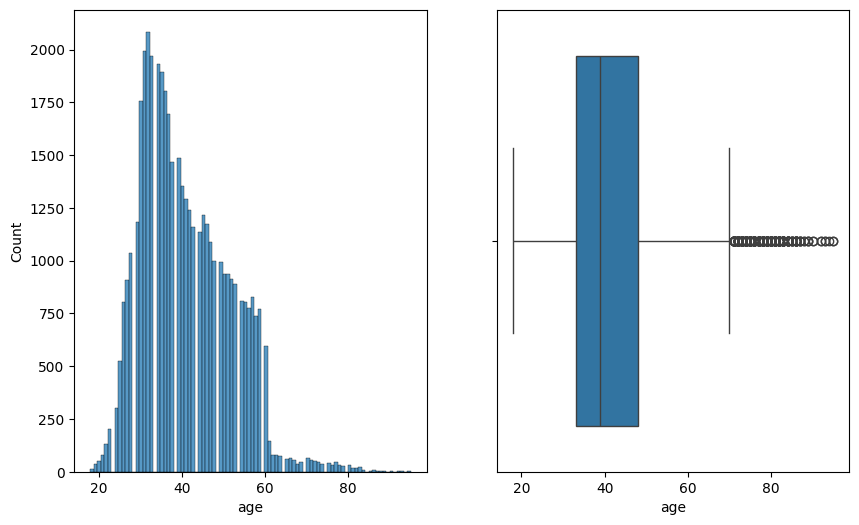

In [14]:
#Lets start with histogram and boxplot
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.histplot(data = df, x = "age")
plt.subplot(1,2,2)
sns.boxplot(data = df, x = "age")
plt.show();

I observe some outliers, lets check them.

In [15]:
df[df["age"] > 70].sort_values(by = "age")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
42197,71,housemaid,divorced,primary,no,1311,no,no,cellular,10,nov,301,2,91,1,success,yes
40383,71,retired,married,tertiary,no,2887,no,no,cellular,30,jun,128,1,-1,0,unknown,yes
40381,71,retired,married,secondary,no,1998,no,no,cellular,23,jun,201,1,-1,0,unknown,no
41562,71,retired,divorced,tertiary,yes,1236,yes,no,cellular,14,sep,335,4,-1,0,unknown,yes
40957,71,retired,married,secondary,no,3,no,no,cellular,13,aug,1175,3,189,1,other,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44262,93,retired,married,unknown,no,775,no,no,cellular,22,jul,860,2,177,7,success,yes
44420,93,retired,married,unknown,no,775,no,no,cellular,4,aug,476,2,13,9,success,yes
31233,94,retired,divorced,secondary,no,1234,no,no,cellular,3,mar,212,1,-1,0,unknown,no
41663,95,retired,married,secondary,no,0,no,no,telephone,1,oct,215,1,-1,0,unknown,no


Nice old guys, there is nothing to do. Maybe a cluster as retired old men :)

### Balance

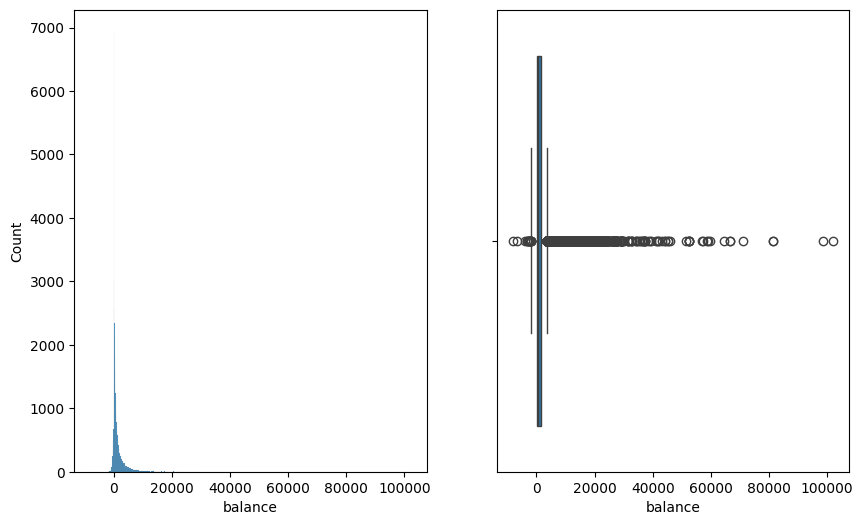

In [16]:
hist_and_boxplot(df, "balance")

Outliers are highly affecting the plots. Lets try somethings.

<Axes: xlabel='balance', ylabel='Count'>

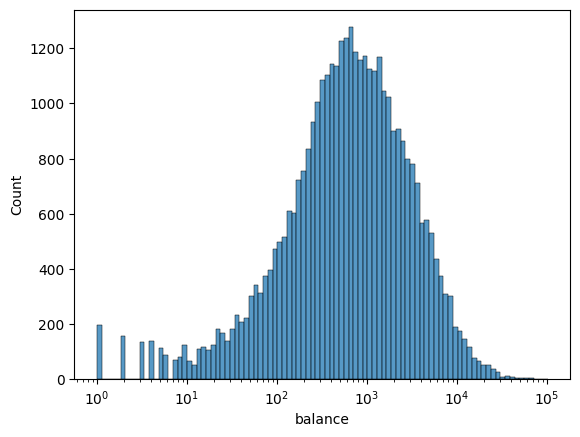

In [17]:
sns.histplot(data = df, x = "balance",log_scale = True)

### Day and Month

In [18]:
df.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [19]:
months = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
df["month"] = df["month"].apply(lambda x: months.index(x)+1)

In [20]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,no


### Campaign

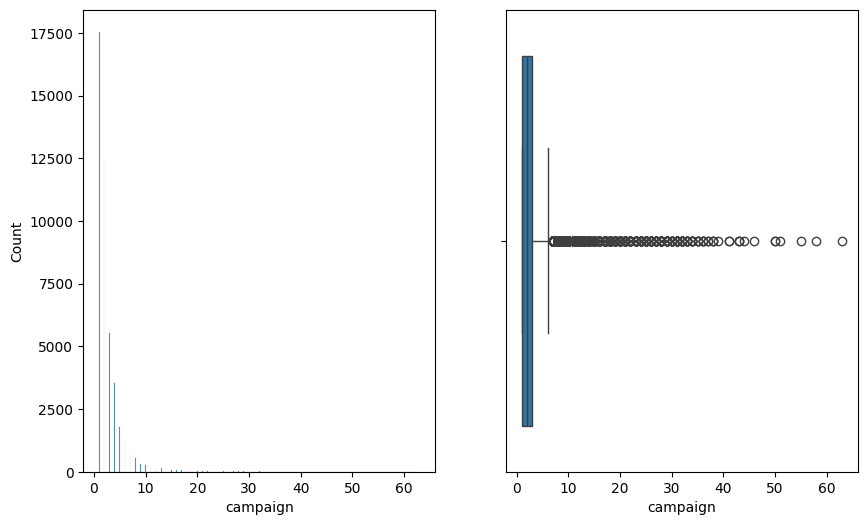

In [21]:
hist_and_boxplot(df, "campaign")

In [22]:
df.campaign.unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44])

### Job

In [23]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

<Axes: ylabel='count'>

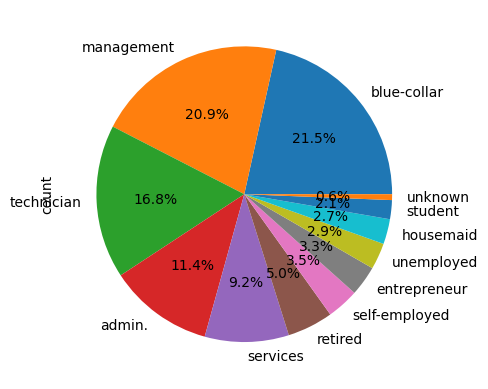

In [24]:
#Lets create a pie chart to see
df.job.value_counts().plot.pie(autopct = "%1.1f%%")

In [25]:
df.job.value_counts()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

After a t test, we may group some of the jobs

### Marital

In [26]:
df.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

<Axes: ylabel='count'>

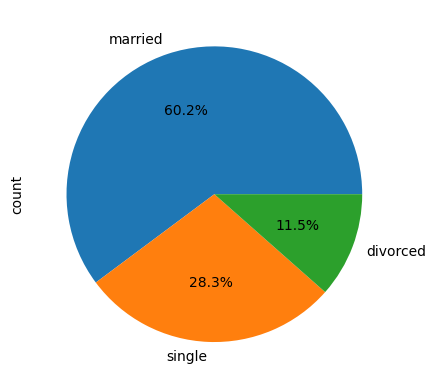

In [27]:
#Pie
df.marital.value_counts().plot.pie(autopct = "%1.1f%%")

Pretty balanced, I will simply one hot encode.

### Education

In [28]:
df.education.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

<Axes: ylabel='count'>

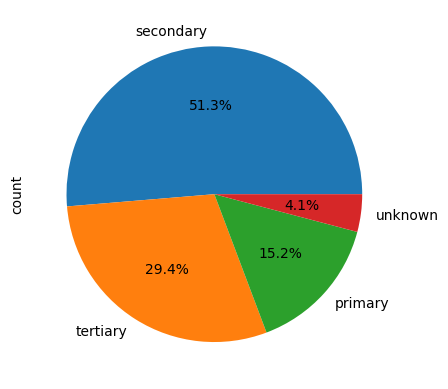

In [29]:
#Pie
df.education.value_counts().plot.pie(autopct = "%1.1f%%")

In [30]:
df.education.value_counts()

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

Seems okey in terms of balance.

### Default

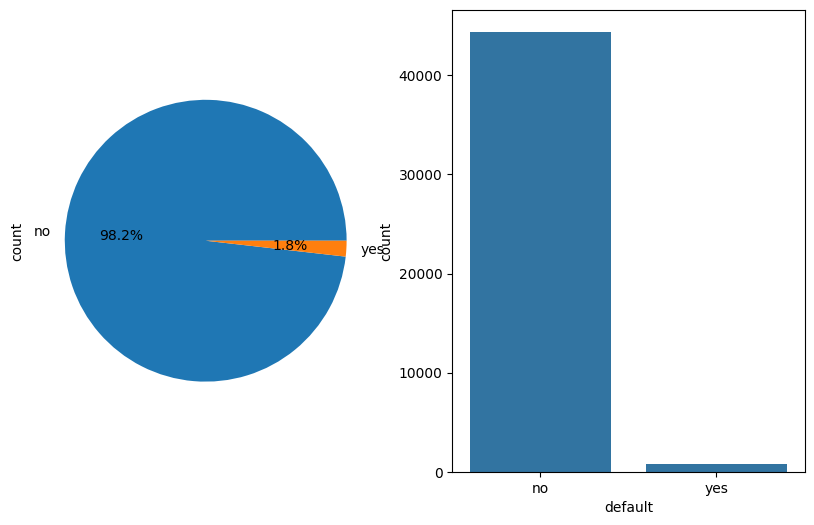

In [31]:
categorical_pie(df, "default")

Number of yes seems relatively low.

### Housing

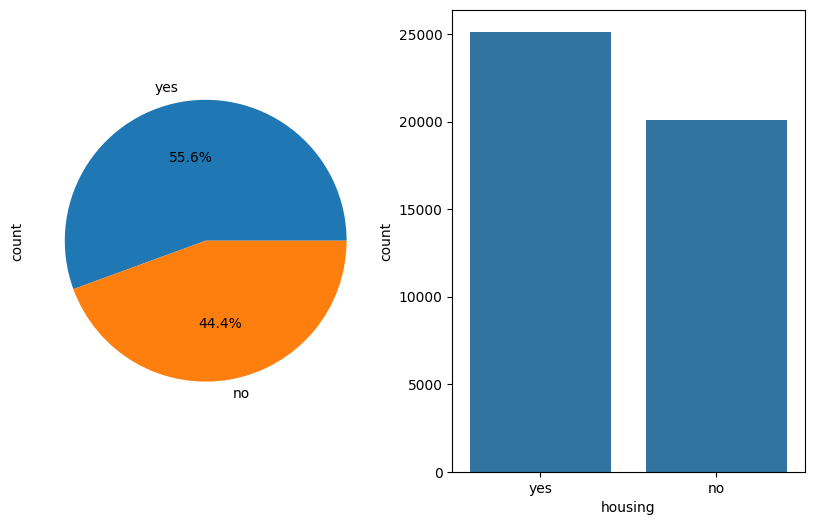

In [32]:
categorical_pie(df, "housing")

### Loan

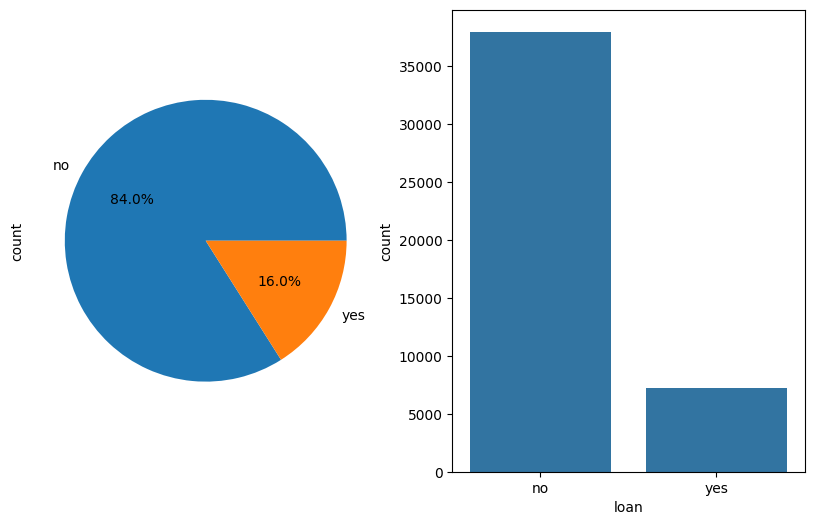

In [33]:
categorical_pie(df, "loan")

### Contact

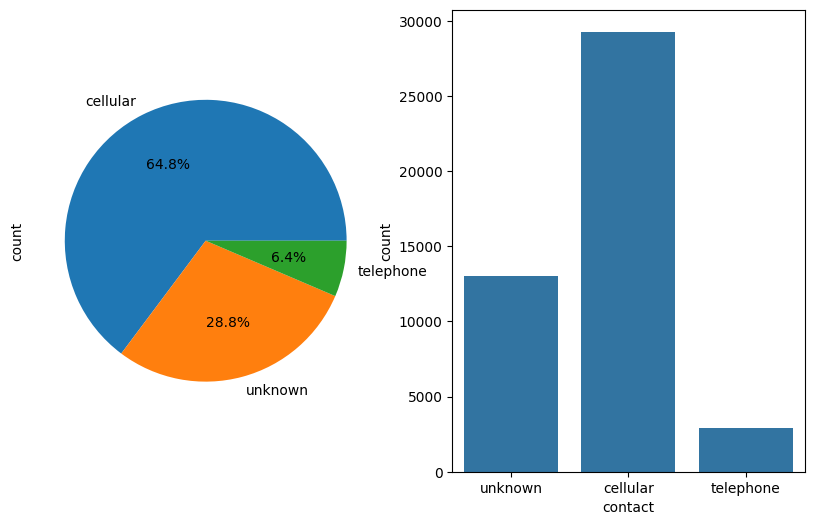

In [34]:
categorical_pie(df, "contact")

Here unknowns may create a problem. We will see after the t test.

### Poutcome

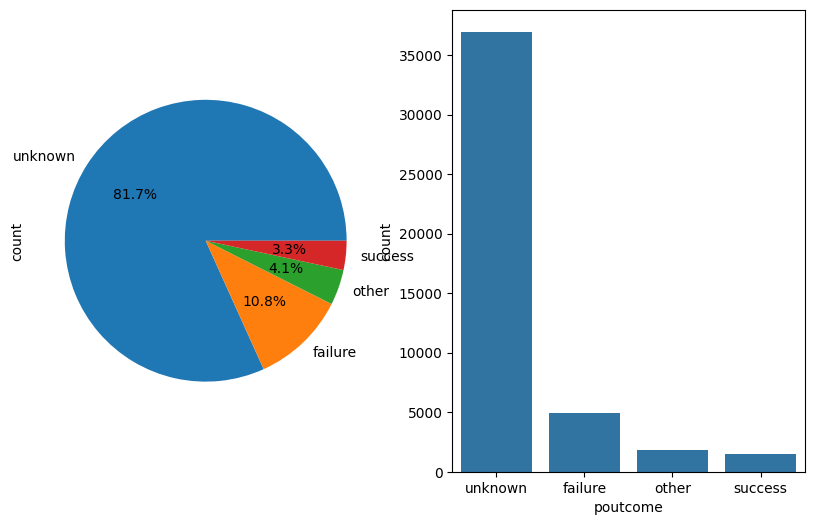

In [35]:
categorical_pie(df, "poutcome")

So many unknown values are frightening.

### y(Target Column)

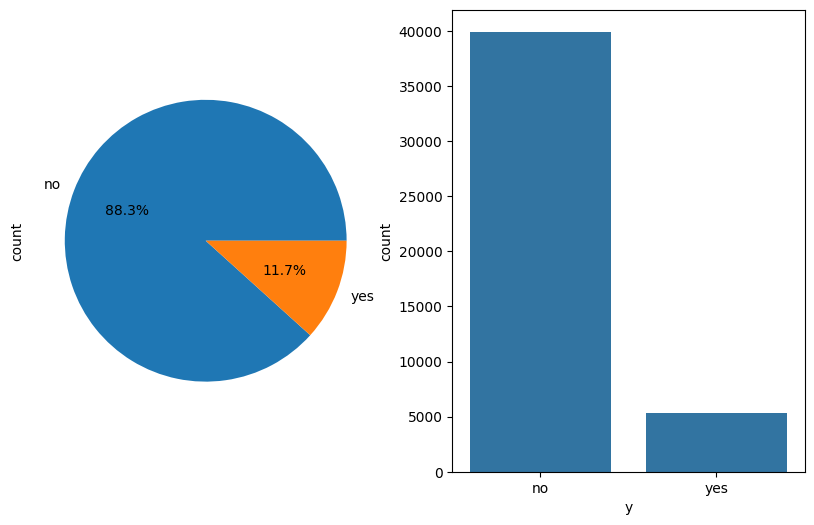

In [36]:
categorical_pie(df, "y")

We are dealing with an unbalanced data. Hence, we should check F-1 score, recall and precision along with the accuracy.

## Numeric Columns Bivariate

<Axes: >

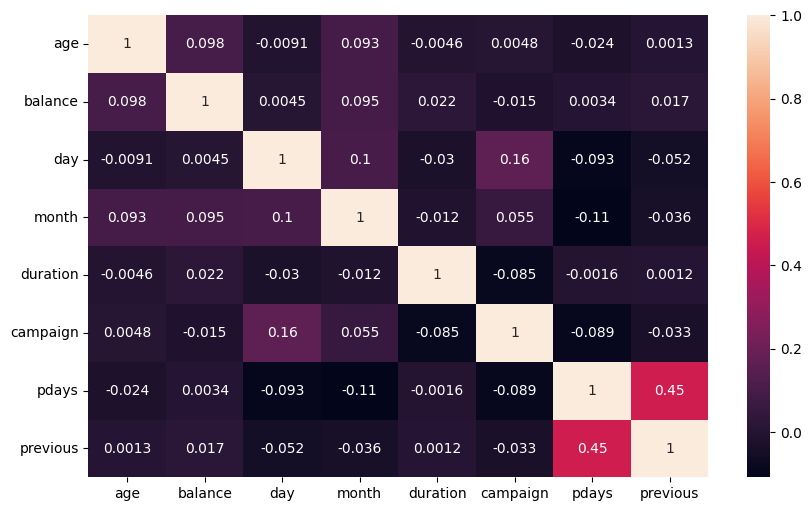

In [37]:
#Lets first look at the correlation map
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True),annot = True)

Take a look:
* day-month
* day-campaign
* month-pdays
* pdays-previous

### Day vs Month

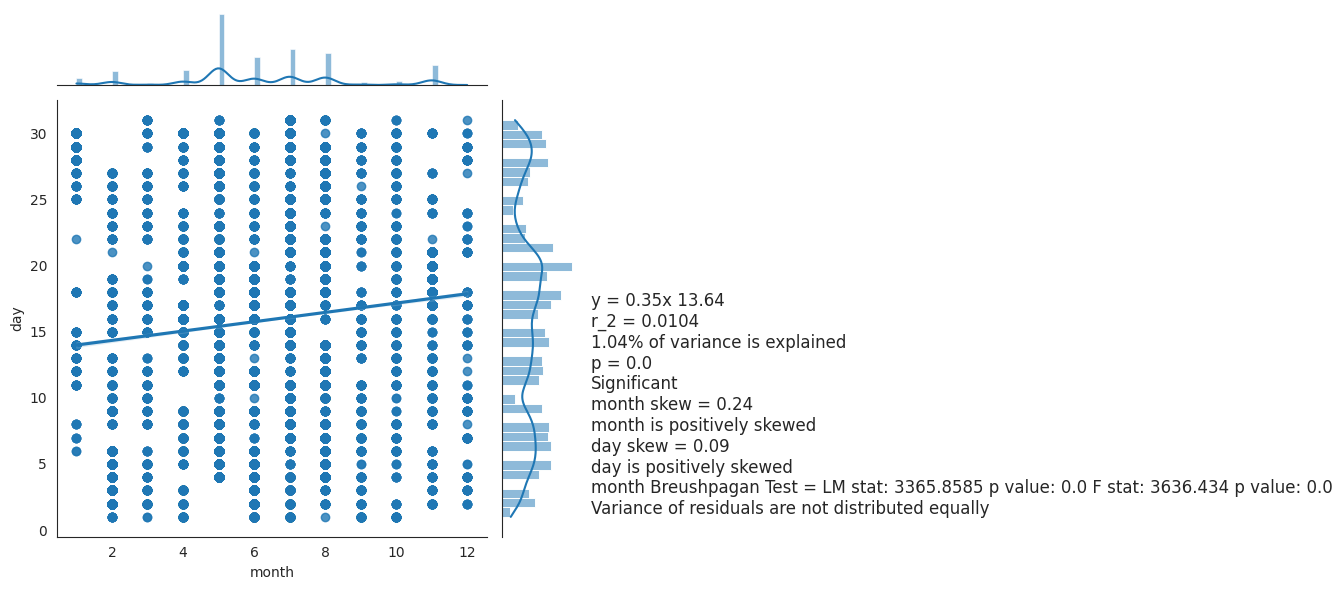

In [38]:
scatter(df, "day", "month")

We can simply use the time lasted from the last call to deter multicollinearity

### Day vs Campaign

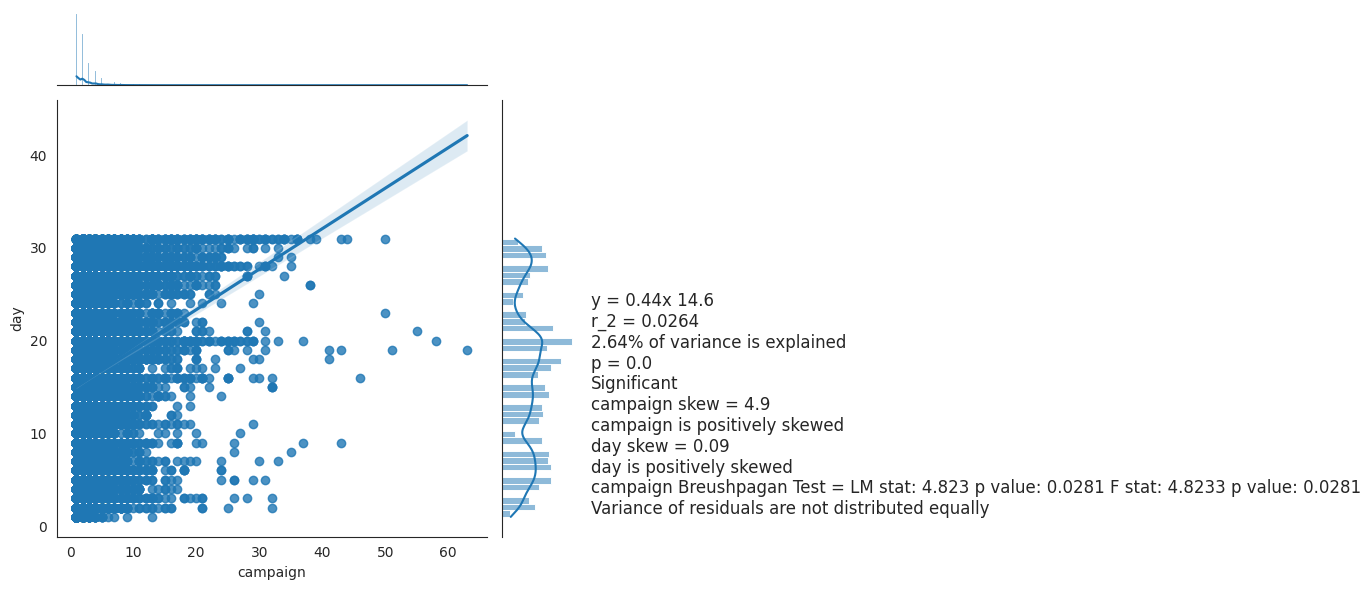

In [39]:
scatter(df, "day", "campaign")

I will simply get rid of the day and month column.

### Month vs Pdays

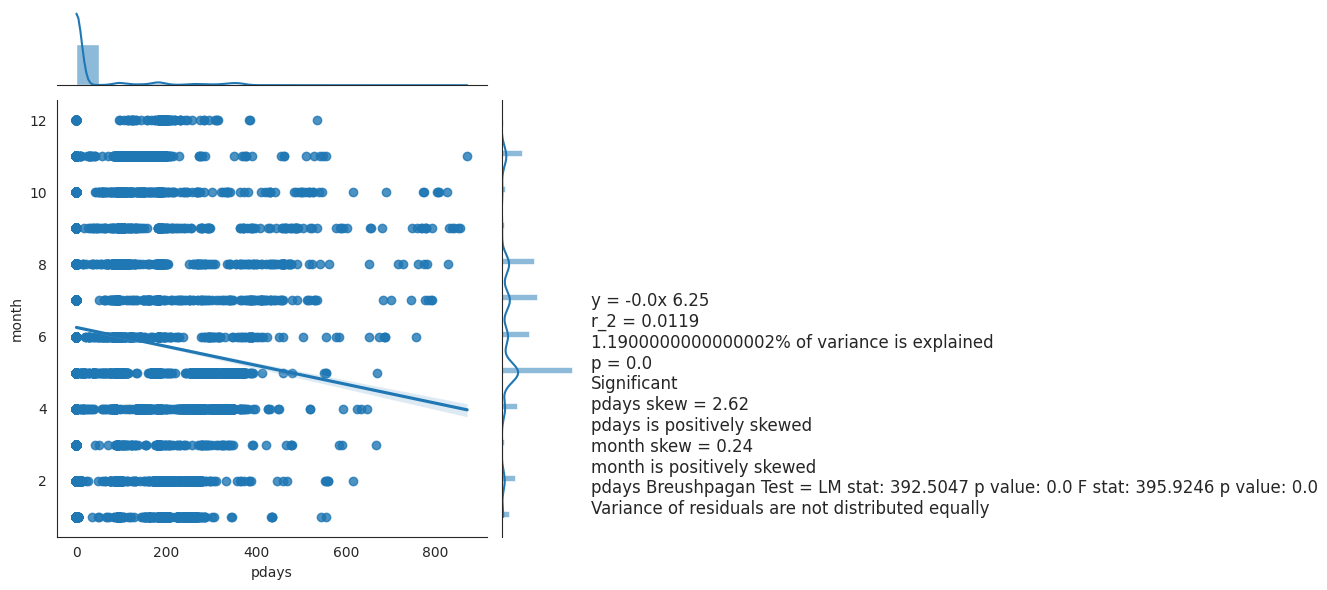

In [40]:
scatter(df, "month", "pdays")

As expected, as month goes back number of pdays increase. Hence using all these features creates problems.

In [41]:
# Lets drop the columns day, month since pdays are enough
df.drop(["day", "month"], axis = 1, inplace = True)

### Previous vs Pdays

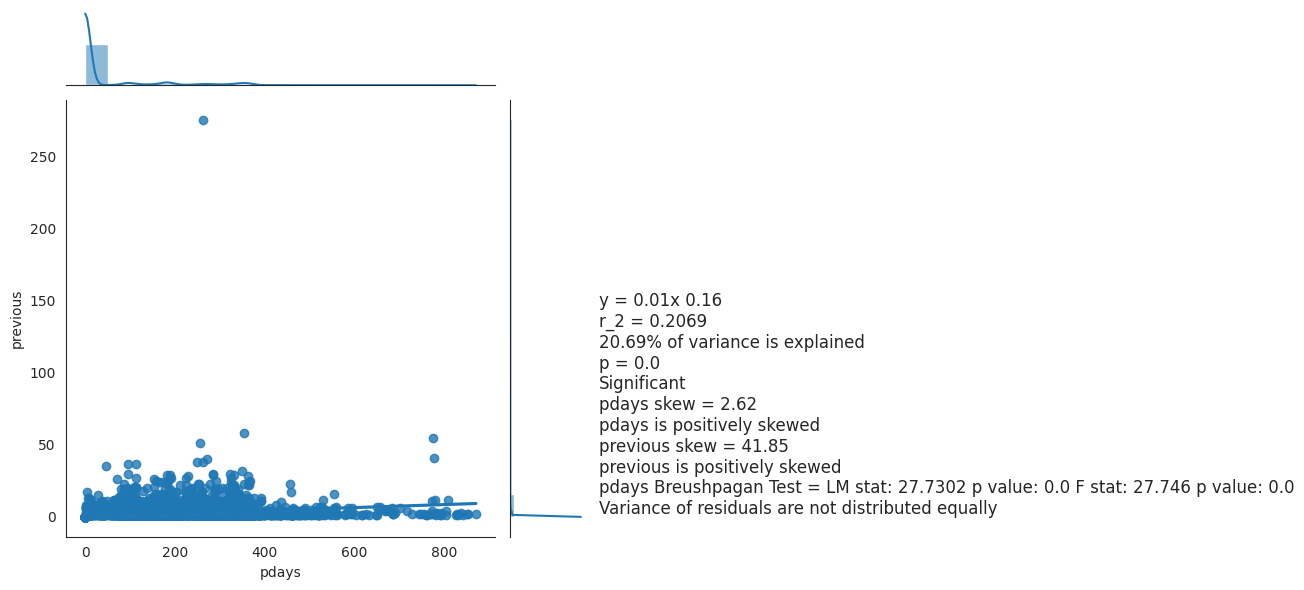

In [42]:
scatter(df, "previous", "pdays")

We have an important multicollinearity problem regarding the pdays and previous since both are similar. I will initially do not touch either column, on the modelling phase I will try with both and only one of them.

## Categorical Bivariate

In [43]:
#Lets first convert target variable into 0-1
df.y.replace({"yes":1, "no":0}, inplace = True)

### Job vs Education

<Axes: xlabel='job', ylabel='count'>

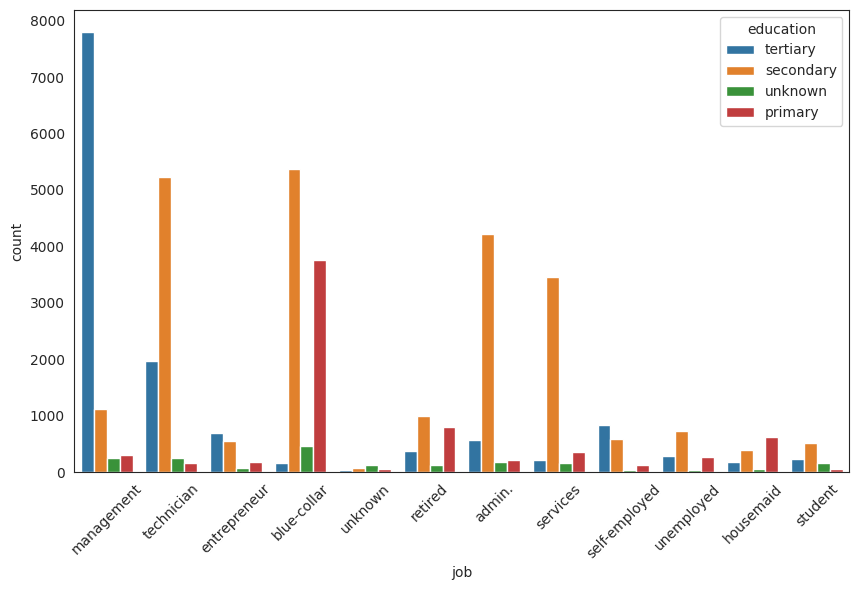

In [44]:
#lets create a plot for jobs hued by education
plt.figure(figsize=(10,6))
plt.xticks(rotation = 45)
sns.countplot(data = df, x = "job", hue = "education")

Observations:
* Management are mostly studied as much as they can :)
* Technicians, blue-collar, admin and services are mostly secondary school.
* Blue-collar also comes from primary school as well

### Education vs Marital

<Axes: xlabel='education', ylabel='count'>

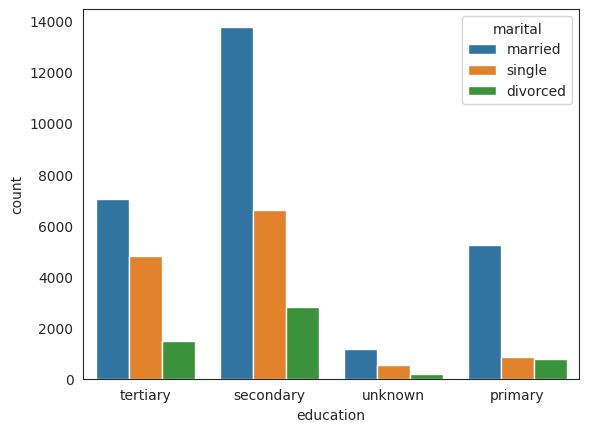

In [45]:
sns.countplot(data = df, x = "education", hue = "marital")

Obs:
* Secondary education seems the best for marrying
* Primary school grads are happilly married and continuing that way.

## Bivariate with Numeric vs Categorical

### Balance vs Education

<Axes: xlabel='education', ylabel='balance'>

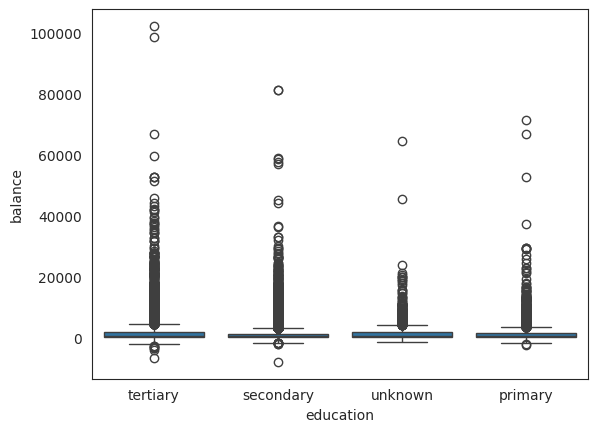

In [46]:
sns.boxplot(data = df, x = "education", y = "balance")

Surprisingly, not much different.

<ipython-input-4-8bf59eebb334>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)


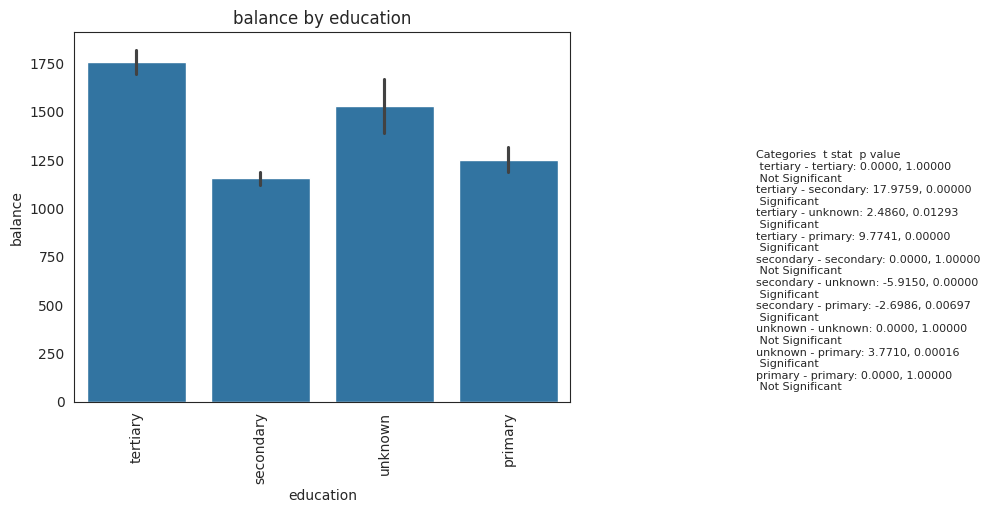

In [47]:
barplots(df, "education", "balance")

Statistical tests also suggests no relation btw education and balance.

### Age vs Housing

<ipython-input-4-8bf59eebb334>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)


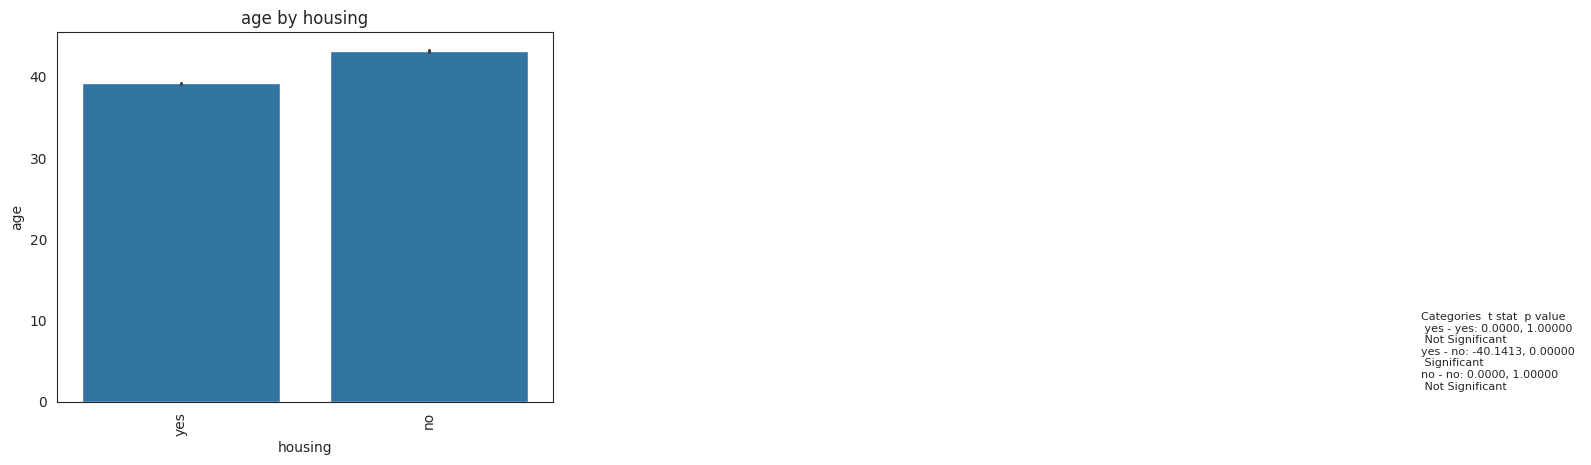

In [48]:
barplots(df, "housing", "age")

<Axes: xlabel='housing', ylabel='age'>

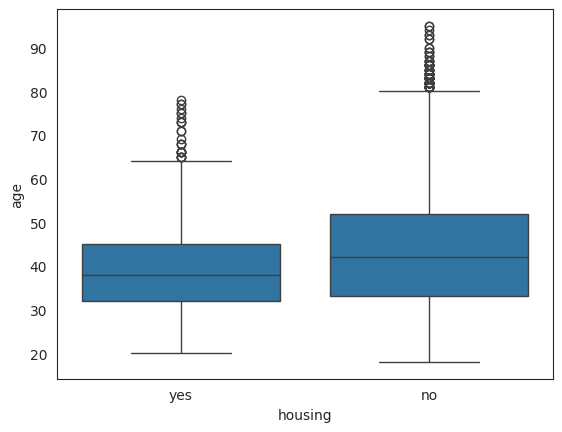

In [49]:
sns.boxplot(data = df, x = "housing", y = "age")

Surprisingly, younger customer tends to have more housing.

# Preprocessing

In [50]:
correlation(df, "y")

,Columns,P-Value,Correlation Coefficient(r),Absolute r
duration,y-duration,0.0,0.394521,0.394521
pdays,y-pdays,0.0,0.103621,0.103621
previous,y-previous,0.0,0.093236,0.093236
campaign,y-campaign,0.0,-0.073172,0.073172
balance,y-balance,0.0,0.052838,0.052838
age,y-age,0.0,0.025155,0.025155


Duration seems to be our key actor in numeric features. Pdays and previous are explaining similar variance, but they are probably explaining the same variance cus of the multicollinearity issues. Campaign and age does not seem well enough.

In [51]:
#Lets one hot encode categorical columns.
df_dummied = pd.get_dummies(df, drop_first = True,dtype=int)

In [52]:
df_dummied.head()

,age,balance,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
1,44,29,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1
2,33,2,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,1
3,47,1506,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1
4,33,1,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1


In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, accuracy_score, f1_score


In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_dummied.drop("y", axis = 1), df_dummied["y"], test_size = 0.2, random_state = 42)

# Modelling

## Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

In [56]:
pipe_log = Pipeline([("scaler", StandardScaler()), ("log_reg", LogisticRegression())])

In [57]:
pipe_log.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg', LogisticRegression())])

In [58]:
auc_score = roc_auc_score(y_test, pipe_log.predict(X_test))
f_1 = f1_score(y_test, pipe_log.predict(X_test))
acc_score = accuracy_score(y_test, pipe_log.predict(X_test))
precision, recall, thresholds = precision_recall_curve(y_test, pipe_log.predict(X_test))

In [59]:
print(f"AUC Score: {auc_score}")
print(f"F-1 Score: {f_1}")
print(f"Accuracy Score: {accuracy_score}")
print(classification_report(y_test, pipe_log.predict(X_test)))

AUC Score: 0.6521229807811119
F-1 Score: 0.43685173886516165
Accuracy Score: <function accuracy_score at 0x7fd4dea58280>
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7952
           1       0.65      0.33      0.44      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.88      9043



<Axes: >

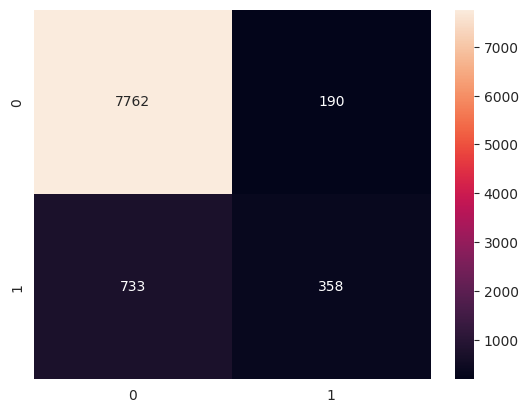

In [60]:
#Lets look at the confustion matrix
sns.heatmap(confusion_matrix(y_test, pipe_log.predict(X_test)), annot = True, fmt = "d")

As expected, it is easy to predict 0 hence our model mostly predicted 0 losing almost 70% of the 1s. Also classification report indicates low recall and precision scores for 1. Which is expected. Lets play with the threshold and see if we can find a better solution.

In [61]:
thresholds = np.arange(0.01,0.99,0.01)

In [62]:
best_score_lg = 0.01
for threshold in thresholds:
  y_pred = (pipe_log.predict_proba(X_test)[:,1]>=threshold)
  # Call the roc_auc_score function
  roc = roc_auc_score(y_test, y_pred)
  if roc > best_score_lg:
    best_score_lg = roc
    best_threshold = threshold
print(f"Best threshold: {best_threshold}")
print(f"Best roc_auc_score: {best_score_lg}")

Best threshold: 0.11
Best roc_auc_score: 0.8199744986878189


In [63]:
roc_auc_score(y_test, pipe_log.predict_proba(X_test)[:,1]>=0.11)

0.8199744986878189

<Axes: >

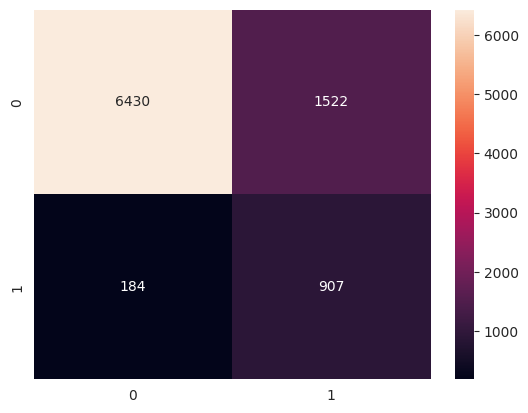

In [64]:
sns.heatmap(confusion_matrix(y_test, pipe_log.predict_proba(X_test)[:,1]>=0.11), annot = True, fmt = "d")

In [65]:
print(classification_report(y_test, pipe_log.predict_proba(X_test)[:,1]>=0.11))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      7952
           1       0.37      0.83      0.52      1091

    accuracy                           0.81      9043
   macro avg       0.67      0.82      0.70      9043
weighted avg       0.90      0.81      0.84      9043



Conclusion:
* Accuracy = 0.81
* AUC = 0.81
* F-1 Score of 1s = 0.52
* Although we are able to almost determine 90% of buyers, we are also mispredicting almost 20% of non buyers as buyers

## Naive Bayes

In [66]:
from sklearn.naive_bayes import GaussianNB

In [67]:
nb_pipe = Pipeline([("scaler", StandardScaler()), ("nb", GaussianNB())])

In [68]:
nb_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('nb', GaussianNB())])

In [69]:
def get_classification_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = "d")
    print(f"AUC Score: {auc_score}")
    print(f"F-1 Score: {f_1}")

              precision    recall  f1-score   support

           0       0.93      0.86      0.90      7952
           1       0.34      0.51      0.41      1091

    accuracy                           0.82      9043
   macro avg       0.63      0.69      0.65      9043
weighted avg       0.86      0.82      0.84      9043

AUC Score: 0.6521229807811119
F-1 Score: 0.43685173886516165


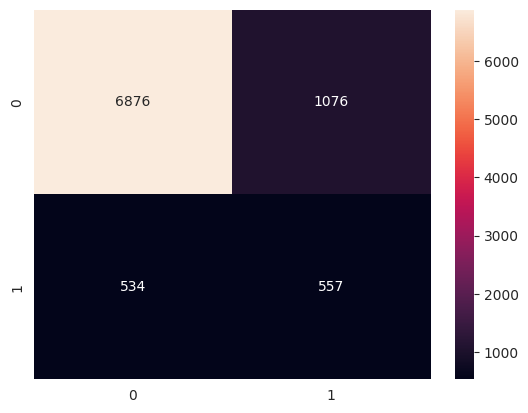

In [70]:
get_classification_report(nb_pipe, X_test, y_test)

In [71]:
# Lets optimize the threshold
best_score_nb = 0.01
for threshold in thresholds:
  y_pred = (nb_pipe.predict_proba(X_test)[:,1]>=threshold)
  # Call the roc_auc_score function
  roc = roc_auc_score(y_test, y_pred)
  if roc > best_score_nb:
    best_score_nb = roc
    best_threshold = threshold
print(f"Best threshold: {best_threshold}")
print(f"Best roc_auc_score: {best_score_nb}")

Best threshold: 0.02
Best roc_auc_score: 0.7306879199117713


<Axes: >

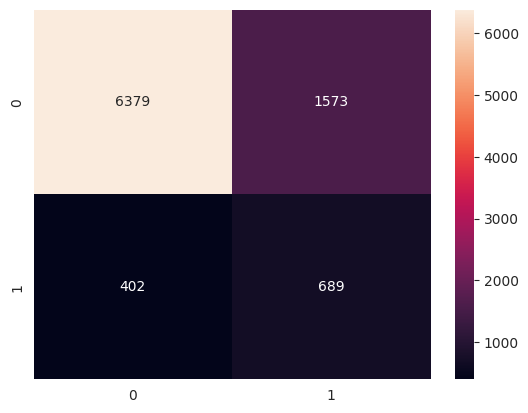

In [72]:
sns.heatmap(confusion_matrix(y_test, nb_pipe.predict_proba(X_test)[:,1]>=0.11), annot = True, fmt = "d")

Our AUC dropped to 0.73 hence we are not even classifiyn 1s with such low threshold and misspredicting 0s nearly same as log reg.

## KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier


In [74]:
knn_pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

In [75]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7952
           1       0.57      0.32      0.41      1091

    accuracy                           0.89      9043
   macro avg       0.74      0.64      0.68      9043
weighted avg       0.87      0.89      0.87      9043

AUC Score: 0.6521229807811119
F-1 Score: 0.43685173886516165


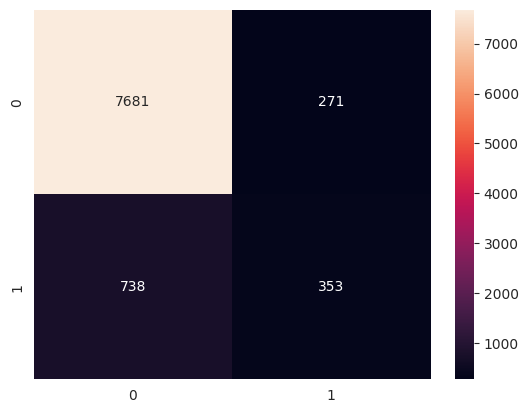

In [76]:
get_classification_report(knn_pipe, X_test, y_test)

In [77]:
#find best threshold
# Lets optimize the threshold
best_score_knn = 0.01
for threshold in thresholds:
  y_pred = (knn_pipe.predict_proba(X_test)[:,1]>=threshold)
  # Call the roc_auc_score function
  roc = roc_auc_score(y_test, y_pred)
  if roc > best_score_knn:
    best_score_knn = roc
    best_threshold = threshold
print(f"Best threshold: {best_threshold}")
print(f"Best roc_auc_score: {best_score_knn}")

Best threshold: 0.01
Best roc_auc_score: 0.7699025269859303


<Axes: >

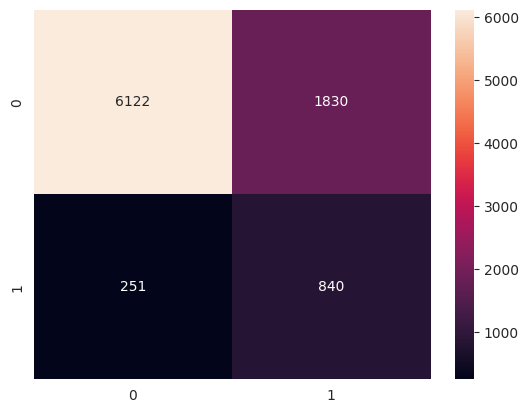

In [78]:
sns.heatmap(confusion_matrix(y_test, knn_pipe.predict_proba(X_test)[:,1]>=0.11), annot = True, fmt = "d")

Our AUC score is again less than logistic regression but better than Naive Bayes

## SVM

In [79]:
from sklearn.svm import SVC

In [80]:
svm_pipe = Pipeline([("scaler", StandardScaler()), ("svm", SVC())])

In [81]:
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7952
           1       0.69      0.27      0.39      1091

    accuracy                           0.90      9043
   macro avg       0.80      0.63      0.67      9043
weighted avg       0.88      0.90      0.88      9043

AUC Score: 0.6521229807811119
F-1 Score: 0.43685173886516165


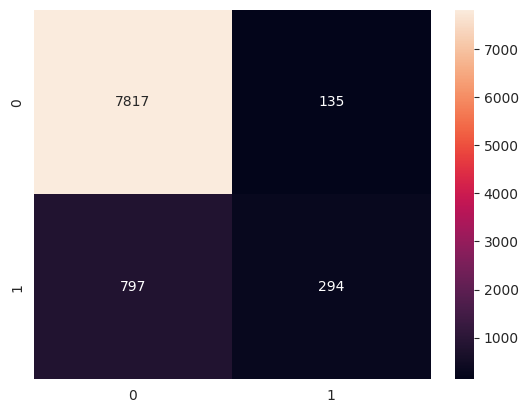

In [82]:
get_classification_report(svm_pipe, X_test, y_test)

In [83]:
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV

In [85]:
kernel = ["linear", "rbf", "poly"]
param_grid = {"svm__kernel": kernel}

In [86]:
svm_grid = GridSearchCV(svm_pipe,param_grid=param_grid, cv = 5)

In [87]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__kernel': ['linear', 'rbf', 'poly']})

In [88]:
best_score_svm = roc_auc_score(y_test, svm_grid.predict(X_test))

<Axes: >

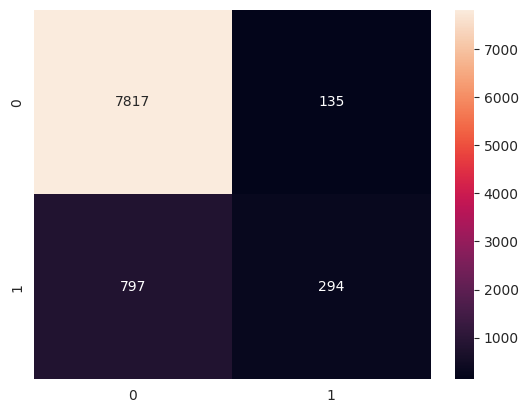

In [89]:
sns.heatmap(confusion_matrix(y_test, svm_grid.predict(X_test)), annot = True, fmt = "d")

There is also probability based thresholding but even this one took more than 46m in the initial setting hence I only selected one parameter to optimize rather than C, gamma etc.

#Comparison of Models

In [90]:
models = ["Logistic Regression", "Naive Bayes", "KNN", "SVM"]
MAE = [best_score_lg,best_score_nb,best_score_knn,best_score_svm]
comparison = pd.DataFrame(columns = ["Model", "MAE"])

Text(0.5, 1.0, 'Model Comparison')

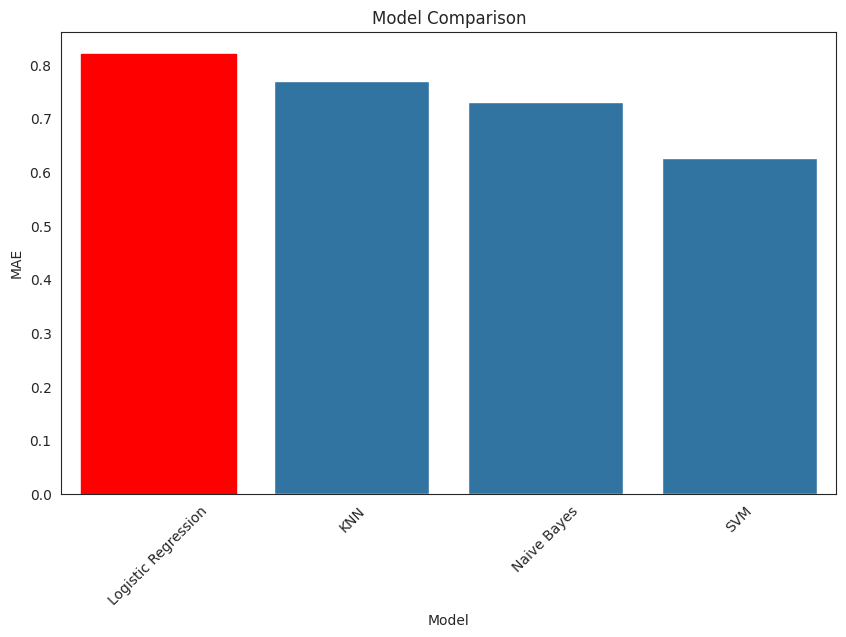

In [92]:
comparison["Model"] = models
comparison["MAE"] = MAE
comparison.sort_values(by = "MAE", inplace = True,ascending=False)
plt.figure(figsize=(10,6))
ax = sns.barplot(data = comparison, x = "Model", y = "MAE")
min_value = comparison["MAE"].min()
max_value = comparison["MAE"].max()
ax.patches[0].set_color('red')
plt.xlabel("Model")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.title("Model Comparison")

Conclusions:
* In datasets that are unbalanced such as this, threshold value is the most vital choose
* Importance of the topic affects the threshold highly
* I tried 4 methods but there can be NN, Boosting methods and many more